# Improving Neural Net Performance

**Learning Objective:** Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE:** The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

Colab link: https://colab.research.google.com/notebooks/mlcc/improving_neural_net_performance.ipynb

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')

chdf = chdf.reindex(np.random.permutation(chdf.index))

In [0]:
def preprocess_features(df):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = df[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = df["total_rooms"] / df["population"]

  # Normalising the features:
  # processed_features -= processed_features.mean()
  # processed_features /= processed_features.std()

  return processed_features

In [0]:
def preprocess_targets(df):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = df["median_house_value"] / 1000.0

  return output_targets

In [0]:
def TrainValTestDataSplit(feat_df, targ_df, train_percentage, val_percentage, test_percentage):

  # Data reshuffled randomly, just in case it hasn't been done yet:
  my_index = np.random.permutation(feat_df.index)
  feat_df = feat_df.reindex(my_index)
  targ_df = targ_df.reindex(my_index)

  # Training, Validation and Test dataset sizes:
  m_train = int(train_percentage*feat_df.shape[0])
  m_test = int(test_percentage*feat_df.shape[0])
  m_val = feat_df.shape[0] - m_train - m_test


  # Splitting DF into training and validation sets:
  training_examples = feat_df.head(m_train)
  training_targets = targ_df.head(m_train)
 
  validation_examples = feat_df.iloc[m_train:m_train+m_val] 
  validation_targets = targ_df.iloc[m_train:m_train+m_val]

  test_examples = feat_df.tail(m_test)  # we take the last examples using the tail command
  test_targets = targ_df.tail(m_test)

  return training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets


In [0]:
# Loading the data:
chdf = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=',')
chdf = chdf.reindex(np.random.permutation(chdf.index))


# Processing the data:
pchdf = preprocess_features(chdf)  # def preprocess_features
ochdf = preprocess_targets(chdf)

print(pchdf.head())
print(ochdf.head())


# Chosen features:
# chosen_features_cols = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# pchdf = pchdf[chosen_features_cols]


# Binning 'Latitude' feature:   # bucketised in feature columns
# pchdf = BinFeature(pchdf, 'latitude', [-2, 3])   # def BinFeature

# display.display(pchdf.head())


# Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[training_examples, training_targets, validation_examples, validation_targets, test_examples, test_targets] = TrainValTestDataSplit(pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit


# Describing the different data sets:
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

       latitude  longitude  ...  median_income  rooms_per_person
7893       34.0     -118.4  ...            3.2               2.2
6728       34.0     -118.3  ...            3.5               2.4
4721       34.0     -118.1  ...            4.0               1.3
915        32.6     -117.1  ...            2.5               1.8
16716      39.1     -122.9  ...            2.0               3.1

[5 rows x 9 columns]
       median_house_value
7893                319.4
6728                134.2
4721                166.7
915                 147.0
16716                78.8
Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,35.6,-119.6,28.6,2653.1,542.1,1430.5,503.4,3.9,2.0
std,2.1,2.0,12.6,2167.5,420.4,1121.7,383.5,1.9,1.2
min,32.5,-124.3,2.0,8.0,1.0,8.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,298.0,792.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2138.5,436.0,1169.0,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3163.8,654.0,1724.8,609.8,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0
mean,35.6,-119.6,28.9,2584.3,524.8,1401.6,488.9,3.9,2.0
std,2.2,2.0,12.7,2150.6,415.0,1082.3,376.6,1.9,1.1
min,32.6,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.1
25%,33.9,-121.7,18.0,1461.2,290.0,779.5,279.0,2.6,1.5
50%,34.2,-118.5,29.0,2083.0,423.0,1154.0,402.0,3.5,1.9
75%,37.7,-118.0,37.0,3102.5,628.0,1694.8,591.0,4.8,2.3
max,41.8,-114.5,52.0,30401.0,4957.0,13251.0,4490.0,15.0,29.4


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0
mean,35.7,-119.6,28.0,2662.2,541.2,1464.6,503.3,3.8,1.9
std,2.2,2.0,12.5,2312.6,439.1,1407.6,403.6,1.9,1.0
min,32.6,-124.2,1.0,12.0,3.0,8.0,3.0,0.5,0.2
25%,33.9,-121.8,18.0,1445.5,299.0,797.2,282.0,2.5,1.5
50%,34.4,-118.9,27.0,2119.0,434.0,1174.0,404.0,3.5,1.9
75%,37.7,-118.0,37.0,3124.0,637.0,1733.5,596.2,4.7,2.3
max,41.6,-115.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,27.1


Training targets summary:


,median_house_value
count,12750.0
mean,207.9
std,116.0
min,15.0
25%,120.4
50%,180.1
75%,266.4
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,207.5
std,116.8
min,22.5
25%,119.2
50%,182.7
75%,261.1
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,202.2
std,114.5
min,26.6
25%,114.7
50%,177.8
75%,257.4
max,500.0


Train the NN:

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object. The Optimiser will be input
  # my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      # activation_fn= relu,  # sigmoid
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], batch_size=1, num_epochs=1, shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(training_predictions, training_targets) )
    validation_root_mean_squared_error = math.sqrt( metrics.mean_squared_error(validation_predictions, validation_targets) )
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(training_predictions, training_targets.values, '.', label='training')
  plt.plot(validation_predictions, validation_targets.values, '.', label='validation')
  plt.ylabel("example labels")
  plt.xlabel("predictions")
  plt.title("Predictions vs. Real Targets")
  plt.grid()
  plt.legend()
  plt.show()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

Training model...
RMSE (on training data):
  period 00 : 163.75
  period 01 : 144.77
  period 02 : 113.85
  period 03 : 104.27
  period 04 : 105.15
  period 05 : 102.29
  period 06 : 111.54
  period 07 : 100.98
  period 08 : 100.79
  period 09 : 100.61
Model training finished.


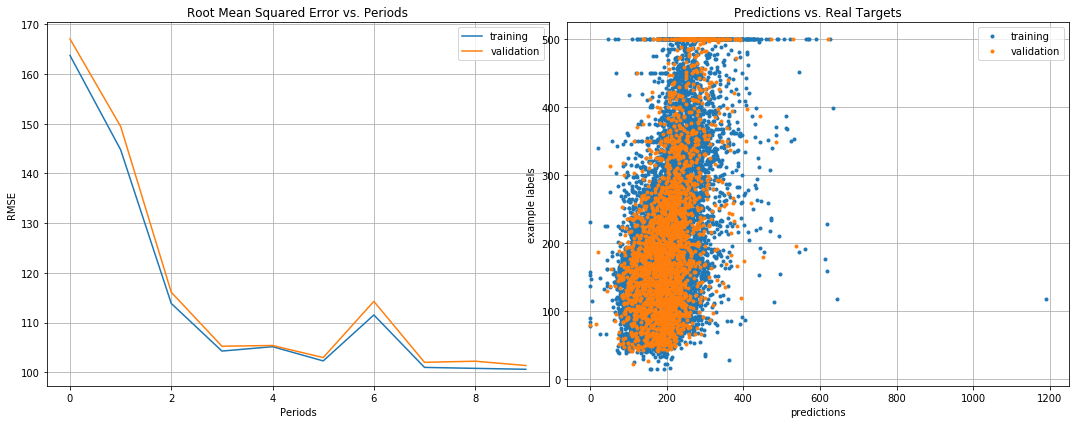

Final RMSE (on training data):   100.61
Final RMSE (on validation data): 101.37


In [0]:
# Call the training model:
learning_rate = 0.001   # 0.0007
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
steps = 8000   # 5000
batch_size = 100   # 70
hidden_units = [20,5]    # [10,10]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  # print(series.head())

  return series.apply( lambda x : ( (x - min_val) / scale ) - 1.0 )

## Task 1: Normalize the Features Using Min-Max Scaling

**Normalize the inputs to the scale -1, 1.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

In [0]:
# Function to normalise the input data via min-max scaling:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #

  normalised_examples_df = pd.DataFrame()
  for col in examples_dataframe.columns[0:] :
    # print(col)
    # print(type(col))
    # print(examples_dataframe[col].head())
    # normalised_series = pd.DataFrame( { col : linear_scale( examples_dataframe[col] ) } )
    # normalised_examples_df.join( normalised_series )
    # print(normalised_series.head())
    # print(normalised_series.columns)
    normalised_examples_df[col] = linear_scale( examples_dataframe[col] )
    # print(normalised_examples_df)

  return normalised_examples_df


Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.3,-0.1,0.1,-0.8,-0.8,-0.9,-0.8,-0.5,-0.9
std,0.5,0.4,0.5,0.1,0.1,0.1,0.1,0.3,0.0
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.5,-0.4,-0.9,-0.9,-0.9,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.1,-0.9,-0.9,-0.9,-0.9,-0.6,-0.9
75%,0.1,0.3,0.4,-0.8,-0.8,-0.9,-0.8,-0.4,-0.9
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0
mean,-0.3,-0.0,0.1,-0.8,-0.8,-0.8,-0.8,-0.5,-0.9
std,0.5,0.4,0.5,0.1,0.2,0.2,0.2,0.3,0.1
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.5,-0.3,-0.9,-0.9,-0.9,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.1,-0.9,-0.8,-0.8,-0.8,-0.6,-0.9
75%,0.1,0.3,0.4,-0.8,-0.7,-0.7,-0.7,-0.4,-0.9
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0
mean,-0.3,0.1,0.1,-0.9,-0.8,-0.9,-0.8,-0.5,-0.9
std,0.5,0.5,0.5,0.1,0.2,0.1,0.2,0.3,0.1
min,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,-0.7,-0.4,-0.3,-0.9,-0.9,-1.0,-0.9,-0.7,-0.9
50%,-0.6,0.2,0.0,-0.9,-0.8,-0.9,-0.8,-0.6,-0.9
75%,0.1,0.4,0.4,-0.8,-0.8,-0.9,-0.8,-0.4,-0.8
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training targets summary:


,median_house_value
count,12750.0
mean,207.9
std,116.0
min,15.0
25%,120.4
50%,180.1
75%,266.4
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,207.5
std,116.8
min,22.5
25%,119.2
50%,182.7
75%,261.1
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,202.2
std,114.5
min,26.6
25%,114.7
50%,177.8
75%,257.4
max,500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e6a071208>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e636bc518>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e67980518>,
      dtype=object)

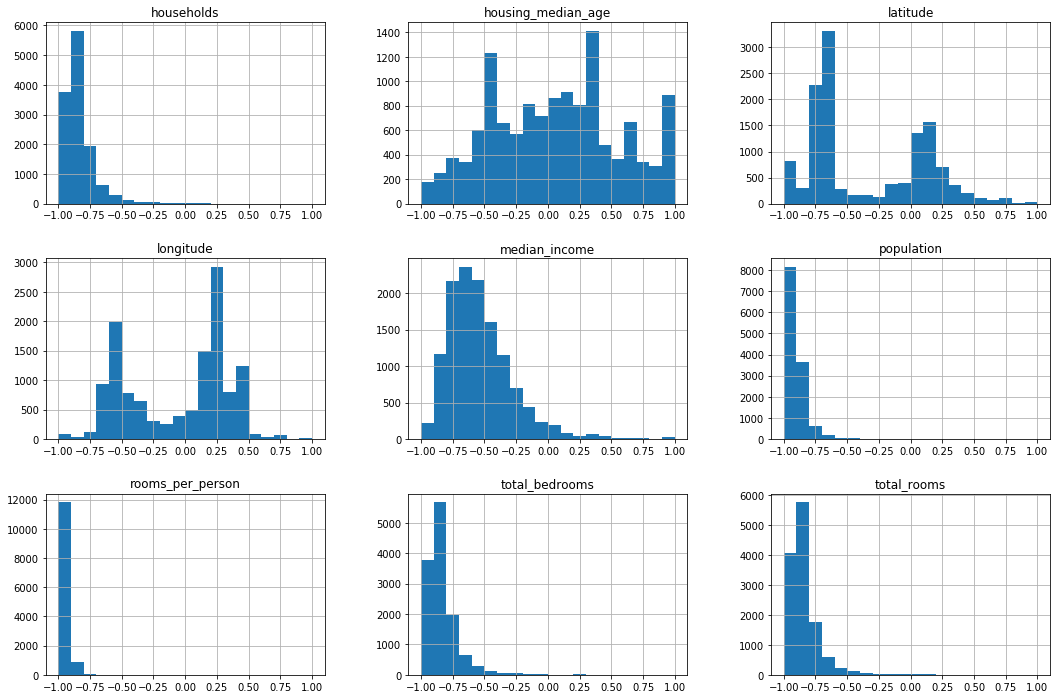

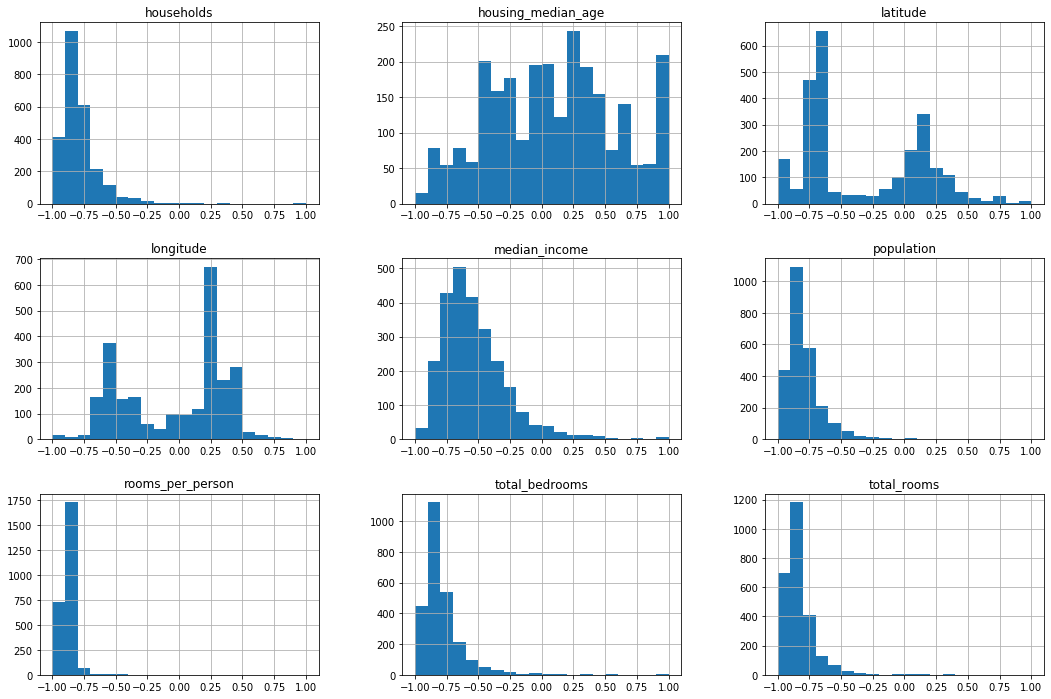

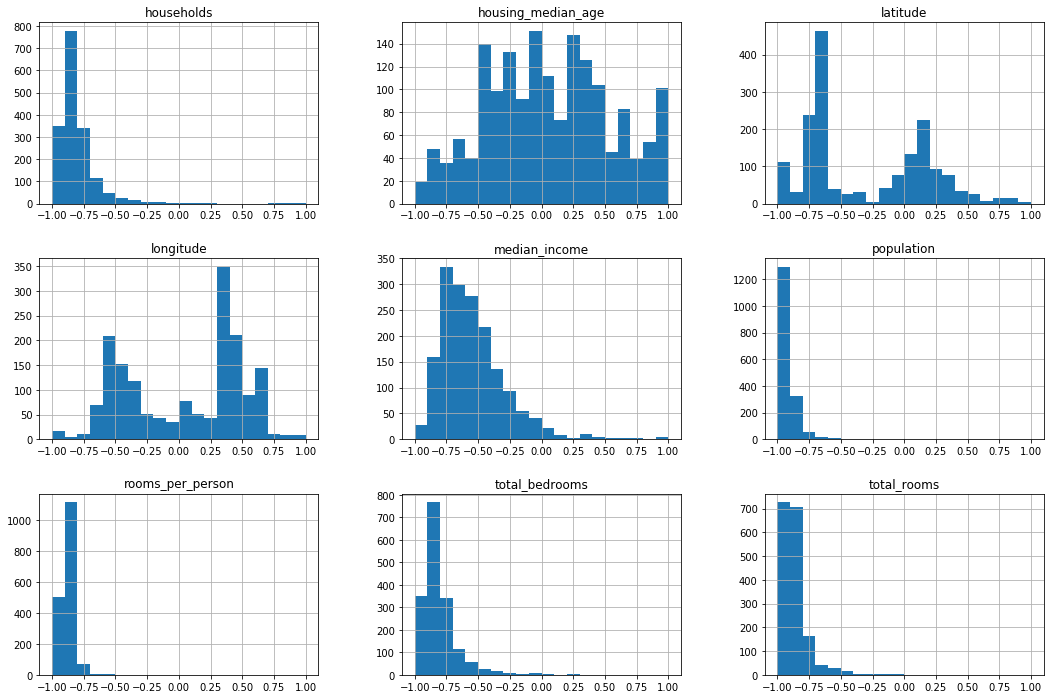

In [0]:
# # Normalising the Original dataframe:
# normalised_pchdf = normalize_linear_scale(preprocess_features(chdf))

# # Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
# train_percentage = 0.75
# val_percentage = 0.15
# test_percentage = 0.10

# [normalised_training_examples, training_targets, normalised_validation_examples, validation_targets, normalised_test_examples, test_targets] = TrainValTestDataSplit(normalised_pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit

# Alternatively, Normalising the original data sets via min-max scaling:
normalised_training_examples = normalize_linear_scale(training_examples)
normalised_validation_examples = normalize_linear_scale(validation_examples)
normalised_test_examples = normalize_linear_scale(test_examples)

# Describing the different data sets:
print("Training examples summary:")
display.display(normalised_training_examples.describe())
print("Validation examples summary:")
display.display(normalised_validation_examples.describe())
print("Test examples summary:")
display.display(normalised_test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

# Histogram of the different features sets:
display.display(normalised_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_test_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))

Training model...
RMSE (on training data):
  period 00 : 225.61
  period 01 : 131.20
  period 02 : 111.25
  period 03 : 98.05
  period 04 : 82.33
  period 05 : 76.33
  period 06 : 74.37
  period 07 : 72.75
  period 08 : 71.85
  period 09 : 71.30
Model training finished.


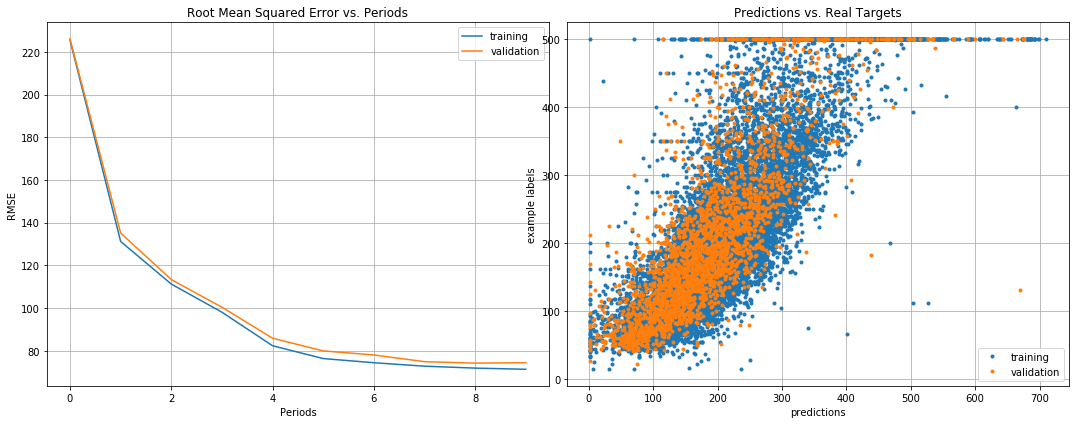

Final RMSE (on training data):   71.30
Final RMSE (on validation data): 74.40


In [0]:
# Call and Train the DNN:
learning_rate = 0.001   # 0.005
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
steps = 8000   # 2000
batch_size = 100   # 50
hidden_units = [20,5]    # [10,10]  # units for each hidden layer  
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)

## Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

Training model...
RMSE (on training data):
  period 00 : 237.65
  period 01 : 237.58
  period 02 : 237.53
  period 03 : 237.48
  period 04 : 237.44
  period 05 : 237.40
  period 06 : 237.37
  period 07 : 237.33
  period 08 : 237.30
  period 09 : 237.27
Model training finished.


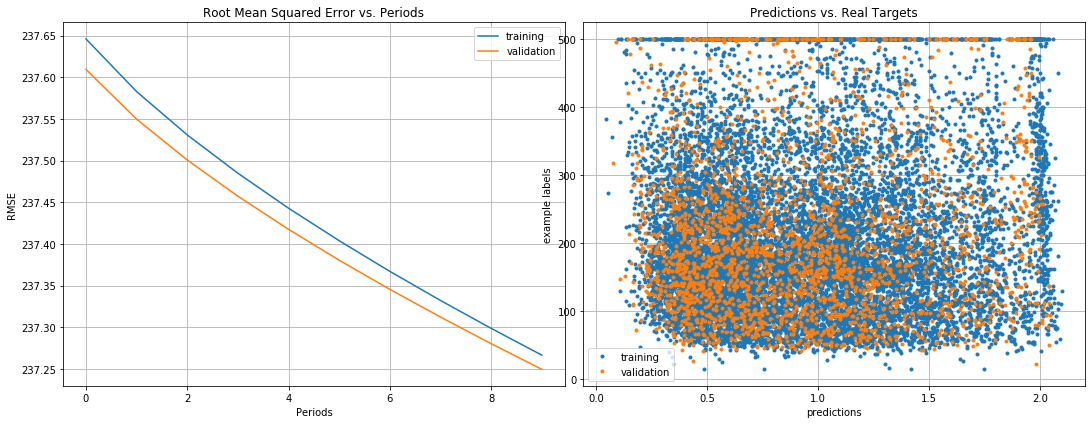

Final RMSE (on training data):   237.27
Final RMSE (on validation data): 237.25


In [0]:
## Adagrad Optimizer:  (instead of the Gradien Descent)

# Call and Train the NN:
learning_rate = 0.1   # 0.5
my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)  # Adagrd Optimiser
steps = 12000   # 500
batch_size = 100   # 100
hidden_units = [20,5]   # [10,10]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 190.01
  period 01 : 114.14
  period 02 : 99.64
  period 03 : 74.81
  period 04 : 69.82
  period 05 : 68.36
  period 06 : 67.59
  period 07 : 67.03
  period 08 : 66.52
  period 09 : 66.26
Model training finished.


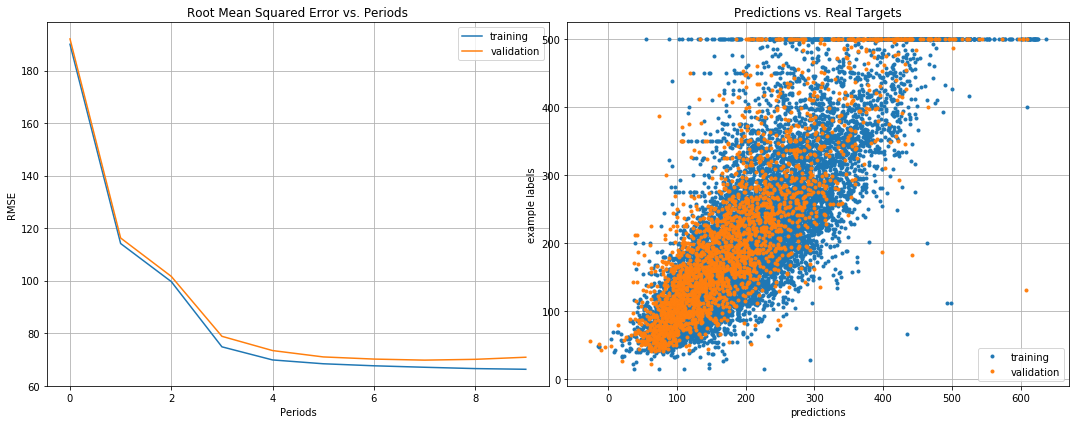

Final RMSE (on training data):   66.26
Final RMSE (on validation data): 70.85


In [0]:
## Adam Optimizer:  (instead of the Gradien Descent)

# Call and Train the NN:
learning_rate = 0.001   # 0.009
my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # Adagrd Optimiser
steps = 8000   # 500
batch_size = 100   # 100
hidden_units = [20,5]    # [10,10]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)

## Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

# Further Normalisation Functions:

In [0]:
# Min-Max Normalisation  (same as above)
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  # print(series.head())
  return series.apply( lambda x : ( (x - min_val) / scale ) - 1.0 )
  
# Log Scaling:
def log_normalise(series):
  return series.apply( lambda x : math.log(x+1.0) )

# Clipping:
def clip(series, clip_to_min, clip_to_max):
  return series.apply( lambda x : (min(max(x, clip_to_min), clip_to_max)) )

# Mean-Std Normalisation (Z-score):
def z_score_normalisation(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply( lambda x : (x-mean)/std_dv )

# Threshold: 
def binary_threshold(series, threshold):
  return series.apply( lambda x : (1 if x > threshold else 0) )

## Normalize the Features Using Mean-Std Scaling



In [0]:
# Function to normalise the input data via z-score scaling:
def normalize_features(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # Normalize the inputs with the chosen Normalisation Function:
  #

  normalised_examples_df = pd.DataFrame()
  for col in examples_dataframe.columns[0:] :
    # normalised_examples_df[col] = linear_scale( examples_dataframe[col] )
    # normalised_examples_df[col] = log_normalise( examples_dataframe[col] )
    # normalised_examples_df[col] = clip( examples_dataframe[col] )
    normalised_examples_df[col] = z_score_normalisation( examples_dataframe[col] )
    # normalised_examples_df[col] = binary_threshold( examples_dataframe[col] )

  return normalised_examples_df


Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.4,-2.4,-2.2,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.3,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.3,0.5,0.3
max,3.0,2.6,1.9,16.2,11.7,29.8,12.2,5.8,45.5


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0
mean,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9
min,-1.4,-2.3,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.6
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,-0.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.6,0.2,0.2,0.3,0.3,0.5,0.3
max,2.9,2.5,1.9,13.8,14.0,23.6,14.5,5.8,27.6


Test examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0
mean,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.8
min,-1.4,-2.4,-2.1,-1.2,-1.3,-1.2,-1.3,-1.8,-1.7
25%,-0.8,-1.1,-0.8,-0.5,-0.6,-0.6,-0.6,-0.7,-0.4
50%,-0.6,0.5,0.0,-0.2,-0.2,-0.2,-0.2,-0.2,-0.0
75%,1.0,0.8,0.7,0.2,0.3,0.3,0.2,0.4,0.3
max,2.9,2.5,1.9,10.7,10.1,7.9,10.4,5.8,13.1


Training targets summary:


,median_house_value
count,12750.0
mean,207.6
std,116.5
min,15.0
25%,119.6
50%,179.8
75%,265.3
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,207.3
std,115.2
min,22.5
25%,120.3
50%,180.9
75%,266.3
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,205.1
std,113.3
min,15.0
25%,118.2
50%,181.6
75%,260.3
max,500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e5b285160>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e5ae313c8>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e5c90f320>,
      dtype=object)

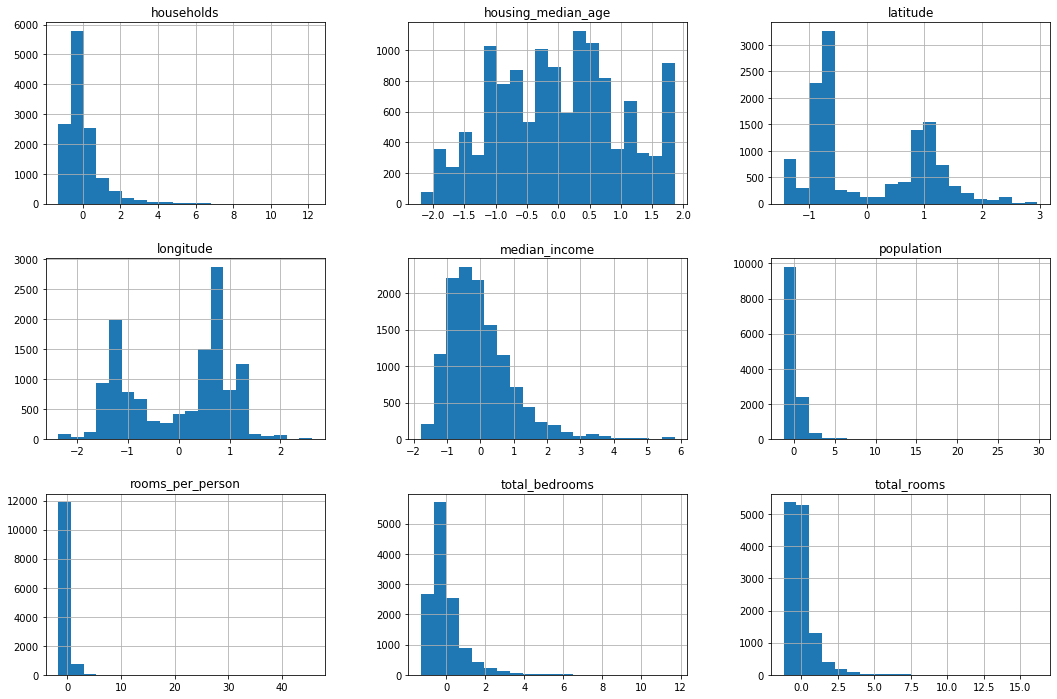

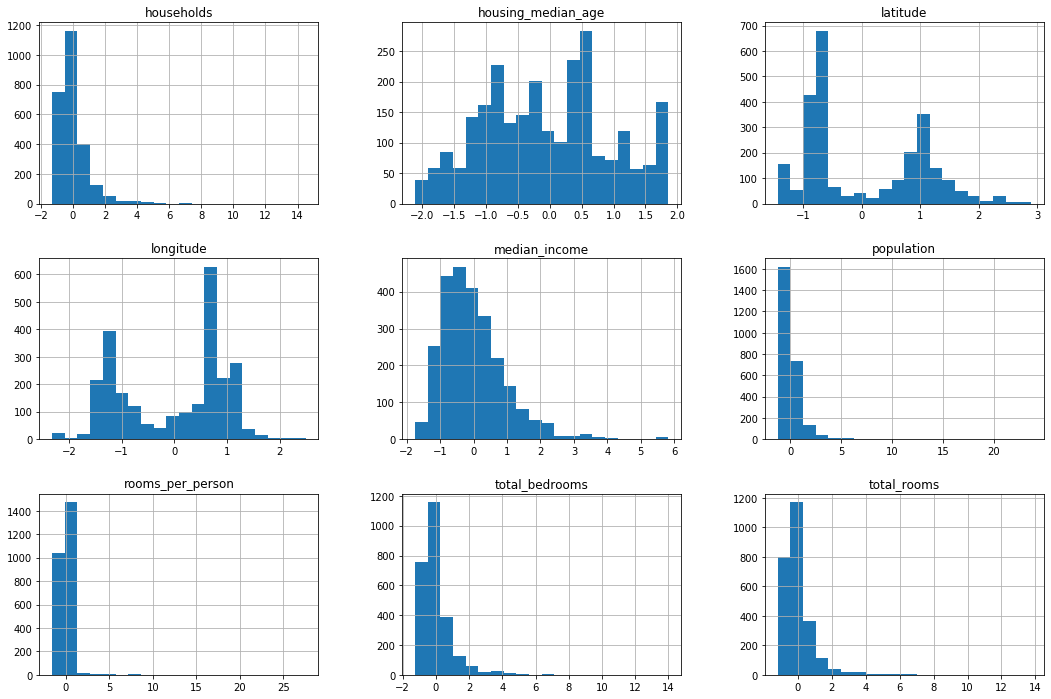

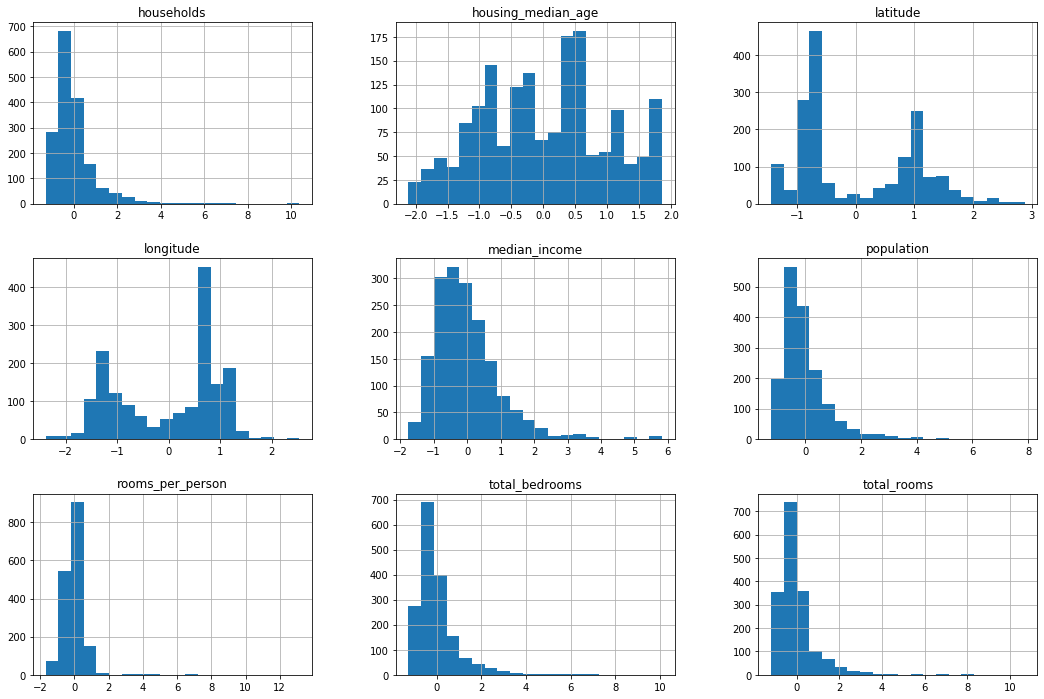

In [0]:
# Normalising the Original dataframe:
normalised_pchdf = normalize_features(preprocess_features(chdf))

# Chosen features:
# chosen_features_cols = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# normalised_pchdf = normalised_pchdf[chosen_features_cols]

# Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[normalised_training_examples, training_targets, normalised_validation_examples, validation_targets, normalised_test_examples, test_targets] = TrainValTestDataSplit(normalised_pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit

# # Alternatively, Normalising the original data sets:
# normalised_training_examples = normalize_features(training_examples)
# normalised_validation_examples = normalize_features(validation_examples)
# normalised_test_examples = normalize_features(test_examples)

# Describing the different data sets:
print("Training examples summary:")
display.display(normalised_training_examples.describe())
print("Validation examples summary:")
display.display(normalised_validation_examples.describe())
print("Test examples summary:")
display.display(normalised_test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

# Histogram of the different features sets:
display.display(normalised_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_test_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))

Training model...
RMSE (on training data):
  period 00 : 212.07
  period 01 : 129.79
  period 02 : 81.60
  period 03 : 73.81
  period 04 : 69.83
  period 05 : 67.80
  period 06 : 66.85
  period 07 : 66.33
  period 08 : 66.01
  period 09 : 65.95
Model training finished.


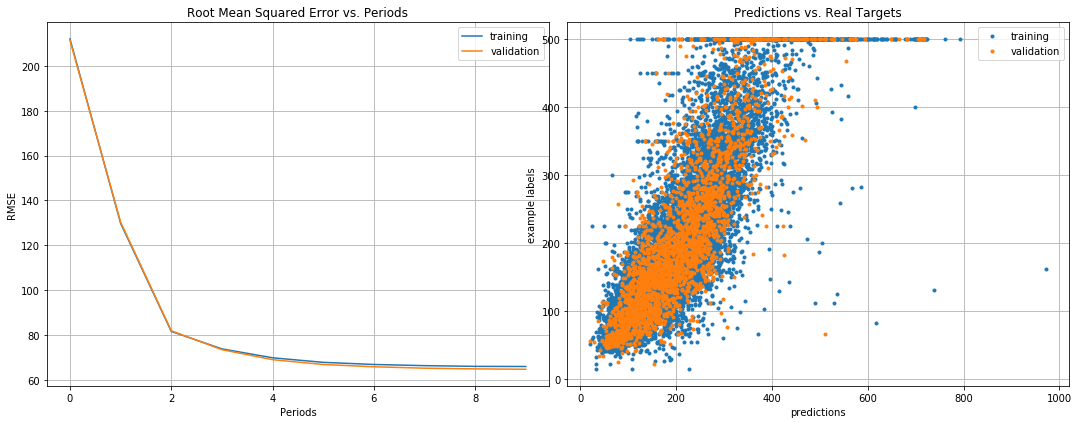

Final RMSE (on training data):   65.95
Final RMSE (on validation data): 64.71


In [0]:
# Call and Train the DNN:
learning_rate = 0.001
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
steps = 8000
batch_size = 100
hidden_units = [20,5]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)

## Normalize the Features with various functions:

These are only a few ways in which we could think about the data. Other transformations may work even better!

`households`, `median_income` and `total_bedrooms` all appear normally-distributed in a log space.

`latitude`, `longitude` and `housing_median_age` would probably be better off just scaled linearly, as before.

`population`, `totalRooms` and `rooms_per_person` have a few extreme outliers. They seem too extreme for log normalization to help. So let's clip them instead.

In [0]:
# Function to normalise the input data:
def normalize_features(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # Normalize the inputs with the chosen Normalisation Function:
  #

  normalised_examples_df = pd.DataFrame()
  # for col in examples_dataframe.columns[0:] :
    # normalised_examples_df[col] = linear_scale( examples_dataframe[col] )
    # normalised_examples_df[col] = log_normalise( examples_dataframe[col] )
    # normalised_examples_df[col] = clip( examples_dataframe[col] )
    # normalised_examples_df[col] = z_score_normalisation( examples_dataframe[col] )
    # normalised_examples_df[col] = binary_threshold( examples_dataframe[col] )

  normalised_examples_df = pd.DataFrame()

  normalised_examples_df["households"] = log_normalise(examples_dataframe["households"])
  normalised_examples_df["median_income"] = log_normalise(examples_dataframe["median_income"])
  normalised_examples_df["total_bedrooms"] = log_normalise(examples_dataframe["total_bedrooms"])
  
  normalised_examples_df["latitude"] = linear_scale(examples_dataframe["latitude"])
  normalised_examples_df["longitude"] = linear_scale(examples_dataframe["longitude"])
  normalised_examples_df["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  normalised_examples_df["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  normalised_examples_df["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  normalised_examples_df["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return normalised_examples_df

Training examples summary:


,households,median_income,total_bedrooms,latitude,longitude,housing_median_age,population,rooms_per_person,total_rooms
count,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0,12750.0
mean,6.0,1.5,6.1,-0.3,-0.0,0.1,-0.4,-0.2,-0.5
std,0.7,0.4,0.7,0.5,0.4,0.5,0.4,0.3,0.4
min,1.1,0.4,1.1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,5.6,1.3,5.7,-0.7,-0.5,-0.3,-0.7,-0.4,-0.7
50%,6.0,1.5,6.1,-0.6,0.2,0.1,-0.5,-0.2,-0.6
75%,6.4,1.8,6.5,0.1,0.3,0.4,-0.3,-0.1,-0.4
max,8.7,2.8,8.8,1.0,1.0,1.0,1.0,1.0,1.0


Validation examples summary:


,households,median_income,total_bedrooms,latitude,longitude,housing_median_age,population,rooms_per_person,total_rooms
count,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0,2550.0
mean,6.0,1.5,6.1,-0.3,-0.0,0.1,-0.4,-0.2,-0.5
std,0.7,0.4,0.7,0.5,0.4,0.5,0.4,0.3,0.4
min,0.7,0.4,0.7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
25%,5.6,1.3,5.7,-0.7,-0.5,-0.3,-0.7,-0.4,-0.7
50%,6.0,1.5,6.1,-0.6,0.2,0.1,-0.5,-0.2,-0.6
75%,6.4,1.7,6.5,0.1,0.3,0.4,-0.3,-0.1,-0.4
max,8.5,2.8,8.5,1.0,0.9,1.0,1.0,1.0,1.0


Test examples summary:


,households,median_income,total_bedrooms,latitude,longitude,housing_median_age,population,rooms_per_person,total_rooms
count,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0
mean,6.0,1.5,6.1,-0.3,-0.1,0.1,-0.4,-0.2,-0.5
std,0.7,0.4,0.7,0.5,0.4,0.5,0.4,0.3,0.4
min,2.6,0.5,2.3,-1.0,-1.0,-1.0,-1.0,-0.9,-1.0
25%,5.7,1.3,5.7,-0.7,-0.5,-0.3,-0.7,-0.4,-0.7
50%,6.0,1.5,6.1,-0.6,0.2,0.1,-0.5,-0.2,-0.6
75%,6.4,1.8,6.5,0.1,0.3,0.4,-0.3,-0.1,-0.4
max,8.2,2.8,8.3,1.0,0.9,1.0,1.0,1.0,1.0


Training targets summary:


,median_house_value
count,12750.0
mean,206.8
std,116.0
min,15.0
25%,118.8
50%,179.4
75%,265.2
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,206.8
std,115.1
min,40.9
25%,121.0
50%,180.9
75%,261.2
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,211.7
std,117.5
min,15.0
25%,121.8
50%,183.6
75%,268.4
max,500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e679226a0>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e5d56acc0>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e5d6d1cf8>,
      dtype=object)

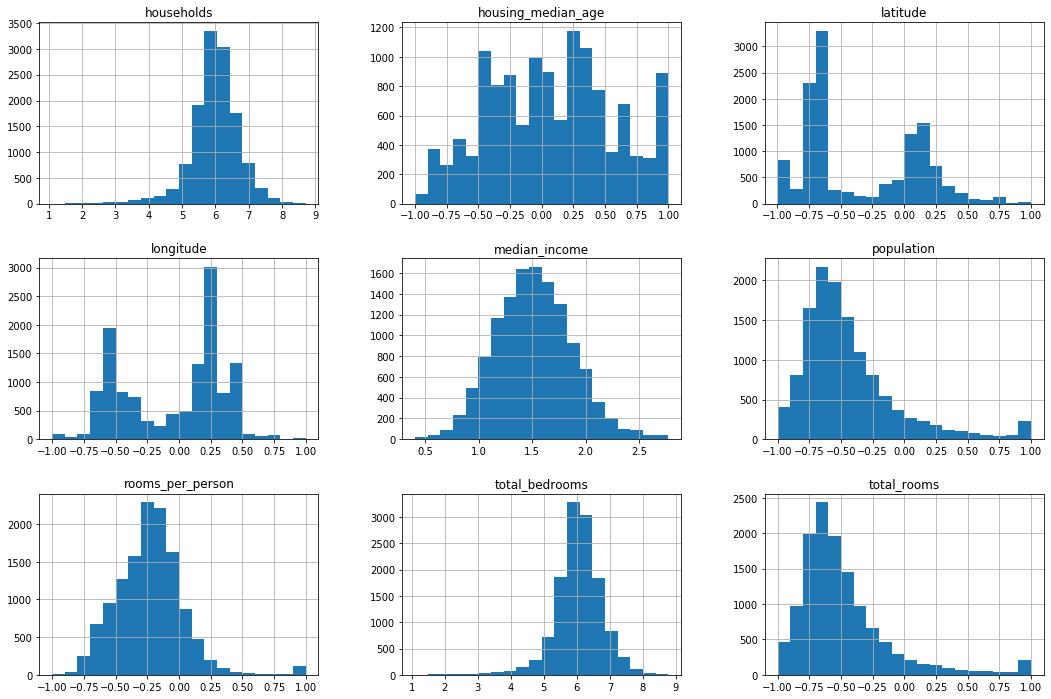

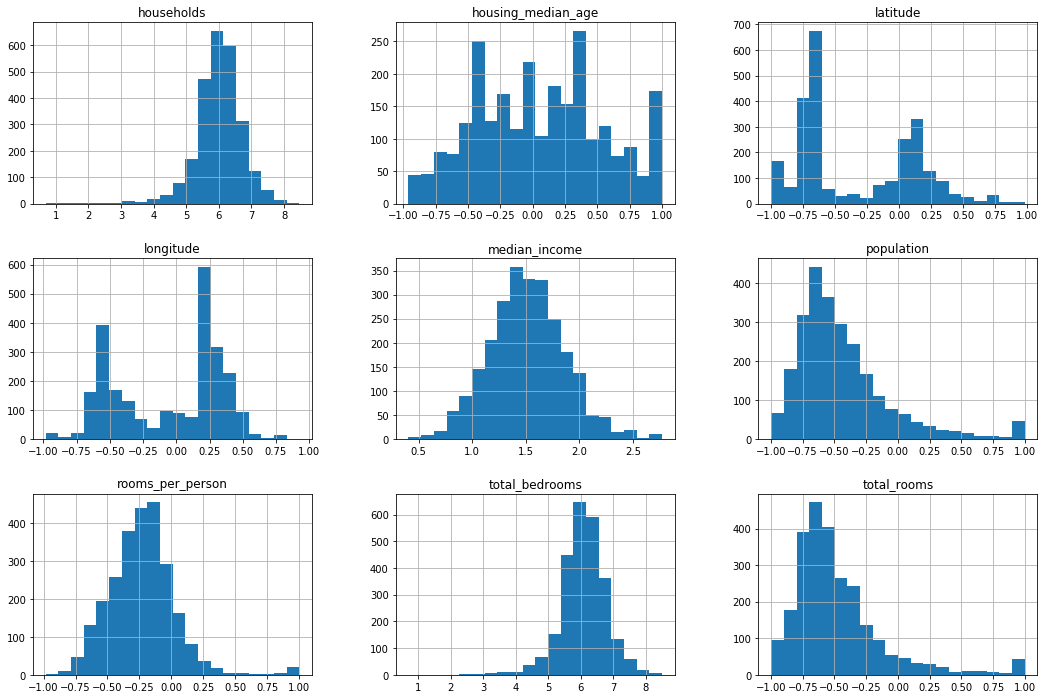

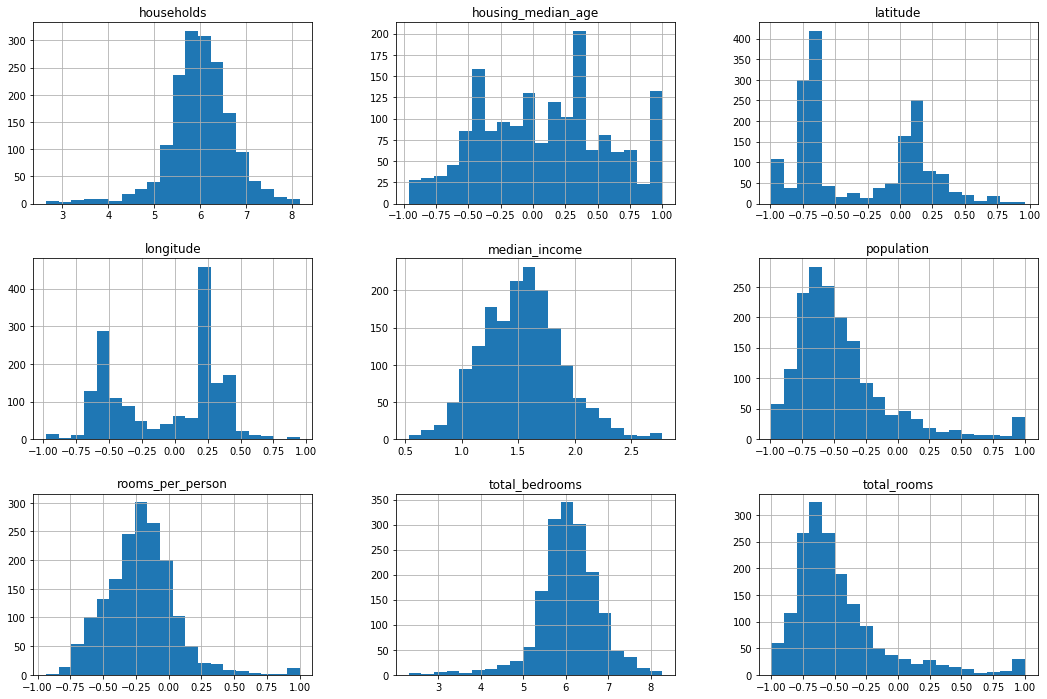

In [0]:
# Normalising the Original dataframe:
normalised_pchdf = normalize_features(preprocess_features(chdf))

# Chosen features:
# chosen_features_cols = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
# normalised_pchdf = normalised_pchdf[chosen_features_cols]

# Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[normalised_training_examples, training_targets, normalised_validation_examples, validation_targets, normalised_test_examples, test_targets] = TrainValTestDataSplit(normalised_pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit

# # Alternatively, Normalising the original data sets:
# normalised_training_examples = normalize_features(training_examples)
# normalised_validation_examples = normalize_features(validation_examples)
# normalised_test_examples = normalize_features(test_examples)

# Describing the different data sets:
print("Training examples summary:")
display.display(normalised_training_examples.describe())
print("Validation examples summary:")
display.display(normalised_validation_examples.describe())
print("Test examples summary:")
display.display(normalised_test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

# Histogram of the different features sets:
display.display(normalised_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_test_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))

Training model...
RMSE (on training data):
  period 00 : 227.85
  period 01 : 113.66
  period 02 : 108.78
  period 03 : 99.97
  period 04 : 87.82
  period 05 : 80.57
  period 06 : 77.67
  period 07 : 76.36
  period 08 : 75.61
  period 09 : 74.84
Model training finished.


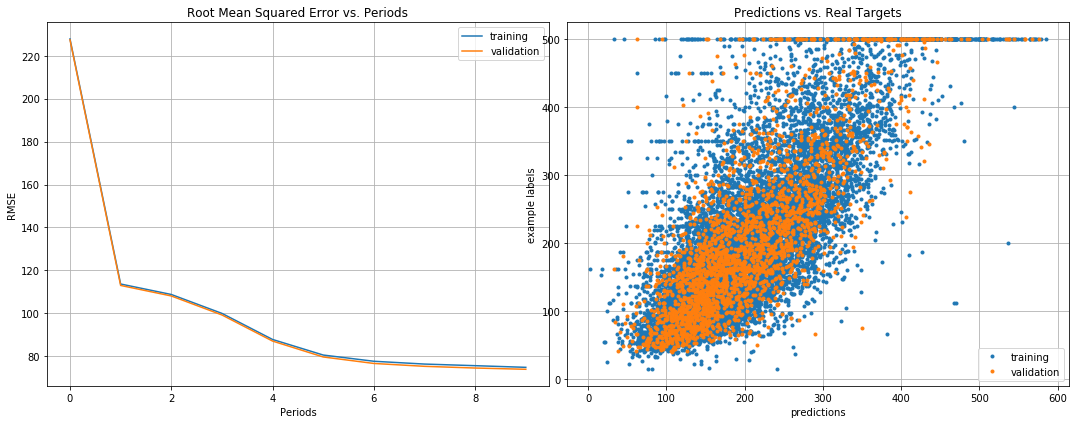

Final RMSE (on training data):   74.84
Final RMSE (on validation data): 73.93


In [0]:
# Call and Train the DNN:
learning_rate = 0.001   # 0.15
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
steps = 8000   # 1000
batch_size = 100   # 50
hidden_units = [20,5]   # [10,10]  # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)

## Optional Challenge: Use only Latitude and Longitude Features

**Train a NN model that uses only latitude and longitude as features.**

Real estate people are fond of saying that location is the only important feature in housing price.
Let's see if we can confirm this by training a model that uses only latitude and longitude as features.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

**NOTE:** We may need a network structure that has more layers than were useful earlier in the exercise.

In [0]:
# Function to normalise the input data:
def normalize_features(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  #
  # Normalize the inputs with the chosen Normalisation Function:
  #

  normalised_examples_df = pd.DataFrame()
  for col in examples_dataframe.columns[0:] :
    # normalised_examples_df[col] = linear_scale( examples_dataframe[col] )
    # normalised_examples_df[col] = log_normalise( examples_dataframe[col] )
    # normalised_examples_df[col] = clip( examples_dataframe[col] )
    normalised_examples_df[col] = z_score_normalisation( examples_dataframe[col] )
    # normalised_examples_df[col] = binary_threshold( examples_dataframe[col] )

  # normalised_examples_df = pd.DataFrame()

  # normalised_examples_df["households"] = log_normalise(examples_dataframe["households"])
  # normalised_examples_df["median_income"] = log_normalise(examples_dataframe["median_income"])
  # normalised_examples_df["total_bedrooms"] = log_normalise(examples_dataframe["total_bedrooms"])
  
  # normalised_examples_df["latitude"] = linear_scale(examples_dataframe["latitude"])
  # normalised_examples_df["longitude"] = linear_scale(examples_dataframe["longitude"])
  # normalised_examples_df["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  # normalised_examples_df["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  # normalised_examples_df["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  # normalised_examples_df["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return normalised_examples_df

Training examples summary:


,longitude,latitude
count,12750.0,12750.0
mean,0.0,-0.0
std,1.0,1.0
min,-2.4,-1.4
25%,-1.1,-0.8
50%,0.5,-0.6
75%,0.8,1.0
max,2.5,3.0


Validation examples summary:


,longitude,latitude
count,2550.0,2550.0
mean,-0.0,0.0
std,1.0,1.0
min,-2.4,-1.4
25%,-1.1,-0.8
50%,0.5,-0.6
75%,0.8,1.0
max,2.5,2.9


Test examples summary:


,longitude,latitude
count,1700.0,1700.0
mean,-0.0,0.0
std,1.0,1.0
min,-2.3,-1.4
25%,-1.1,-0.8
50%,0.5,-0.6
75%,0.8,1.0
max,2.6,3.0


Training targets summary:


,median_house_value
count,12750.0
mean,206.6
std,115.8
min,15.0
25%,118.8
50%,179.4
75%,263.8
max,500.0


Validation targets summary:


,median_house_value
count,2550.0
mean,211.7
std,117.2
min,30.0
25%,125.1
50%,184.9
75%,272.3
max,500.0


Test targets summary:


,median_house_value
count,1700.0
mean,206.1
std,115.7
min,22.5
25%,118.5
50%,177.9
75%,265.4
max,500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e620a27b8>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e634cd908>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e635bb0f0>,
      dtype=object)

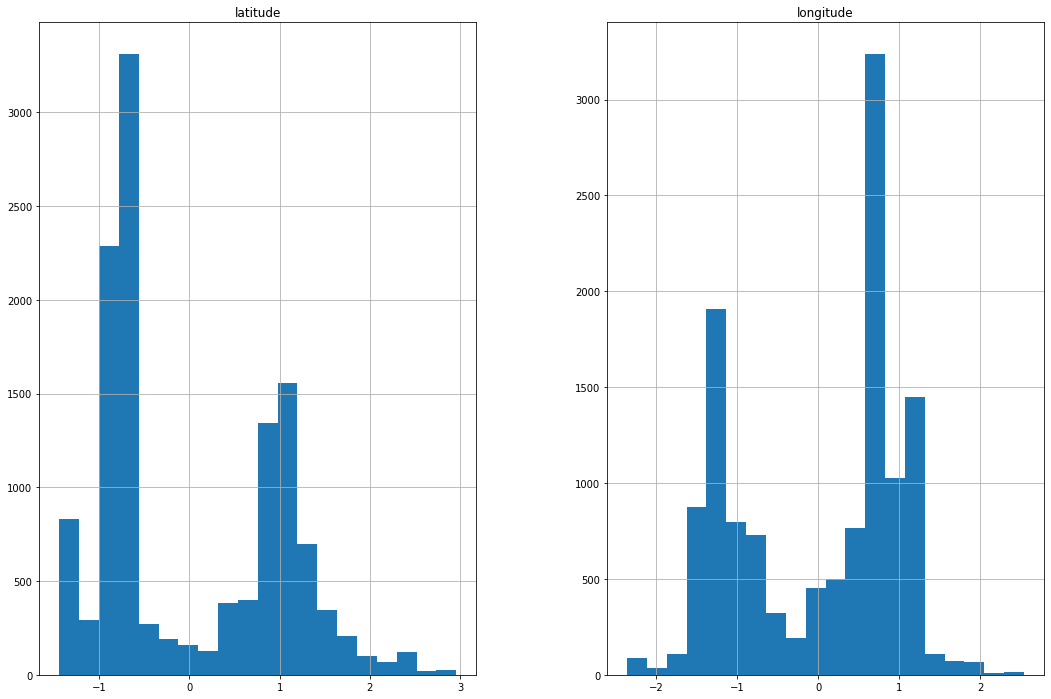

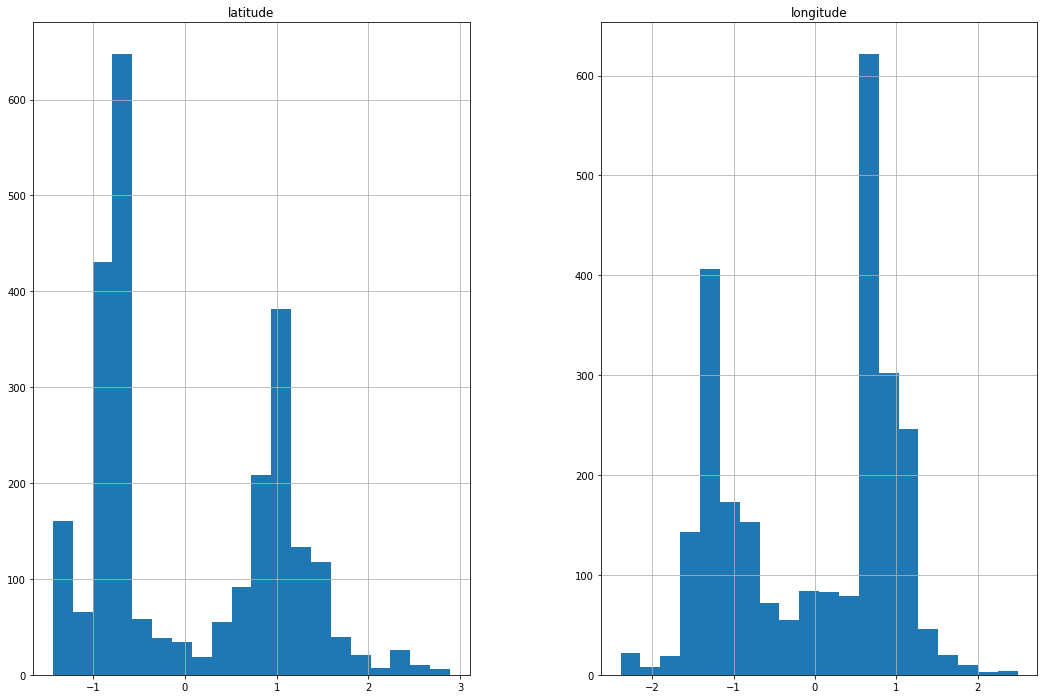

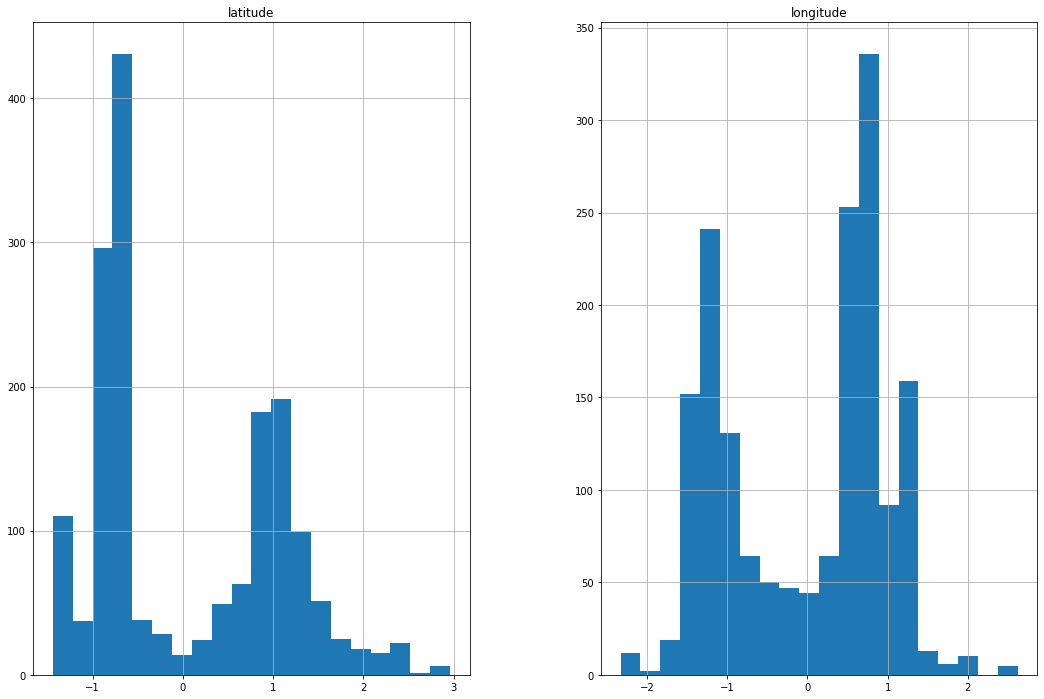

In [0]:
# Normalising the Original dataframe:
normalised_pchdf = normalize_features(preprocess_features(chdf))

# Chosen features:
# chosen_features_cols = ['households', 'longitude', 'latitude', 'housing_median_age', 'median_income', 'rooms_per_person']
chosen_features_cols = ['longitude', 'latitude']
normalised_pchdf = normalised_pchdf[chosen_features_cols]

# Splitting the dataframe into Training, Validation and Test sets (total must sum 1!!!):
train_percentage = 0.75
val_percentage = 0.15
test_percentage = 0.10

[normalised_training_examples, training_targets, normalised_validation_examples, validation_targets, normalised_test_examples, test_targets] = TrainValTestDataSplit(normalised_pchdf, ochdf, train_percentage, val_percentage, test_percentage)  # def TrainValTestDataSplit

# # Alternatively, Normalising the original data sets:
# normalised_training_examples = normalize_features(training_examples)
# normalised_validation_examples = normalize_features(validation_examples)
# normalised_test_examples = normalize_features(test_examples)

# Describing the different data sets:
print("Training examples summary:")
display.display(normalised_training_examples.describe())
print("Validation examples summary:")
display.display(normalised_validation_examples.describe())
print("Test examples summary:")
display.display(normalised_test_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())

# Histogram of the different features sets:
display.display(normalised_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))
display.display(normalised_test_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10))

Training model...
RMSE (on training data):
  period 00 : 234.46
  period 01 : 222.96
  period 02 : 185.57
  period 03 : 137.01
  period 04 : 111.90
  period 05 : 105.31
  period 06 : 101.36
  period 07 : 100.28
  period 08 : 98.54
  period 09 : 98.23
Model training finished.


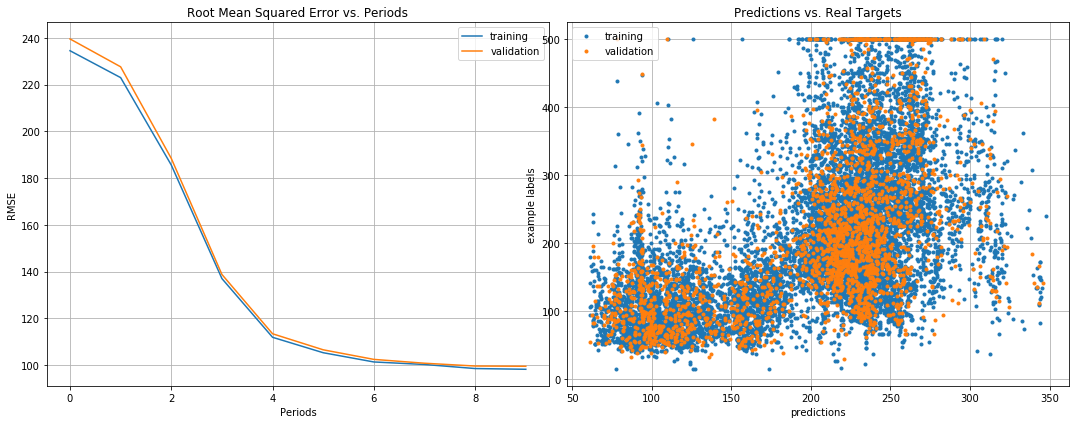

Final RMSE (on training data):   98.23
Final RMSE (on validation data): 99.51


In [0]:
# Call and Train the DNN:
learning_rate = 0.005   # 0.05
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)  # Gradient Descent Optimiser
steps = 500   # 8000 500
batch_size = 100   # 50
hidden_units = [10,10,5,5,5]   # [10,10,5,5,5]   # units for each hidden layer
# Performance improves when normalising the features!!!

dnn_regression = train_nn_regression_model(
    my_optimizer=my_optimizer,
    steps=steps,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalised_training_examples,
    training_targets=training_targets,
    validation_examples=normalised_validation_examples,
    validation_targets=validation_targets)